# 2 - Process the calculation results and calculate trace element concentrations
These notebooks reproduce the results presented in Harðardottir et al. (manuscript submitted). Please contact Simon Matthews (simonm@hi.is) with any queries about the notebook.

This notebook records the second stage of the calculations. The first notebook need not be run first as the previously calculated output is already saved.

First import the required modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyMelt as m
from thermoengine import equilibrate, core, phases, model
from scipy.optimize import root_scalar
from scipy.interpolate import interp1d
from copy import deepcopy, copy

## Import the melting calculation results
The pyroxenite fractions must also be defined here (and should match those used in the previous notebook). 

In [2]:
phi_pxs = [0.025,0.025,0.05]
n = len(phi_pxs)

In [4]:
results = []
for i in range(n):
    if i == 0:
        krdf = pd.read_csv('kr4003_gradient_'+str(2)+'.csv')
        # krdf = krdf[krdf.P>2.0]
        kgdf = pd.read_csv('kg1_gradient_'+str(2)+'.csv')
        # kgdf = kgdf[kgdf.P>2.0]
        results.append([krdf,kgdf])
    else:
        results.append([pd.read_csv('kr4003_gradient_'+str(i)+'.csv'),pd.read_csv('kg1_gradient_'+str(i)+'.csv')])

Check the results look ok by creating plots:

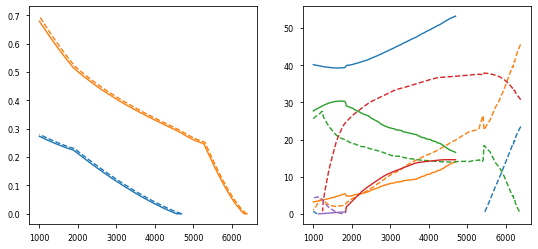

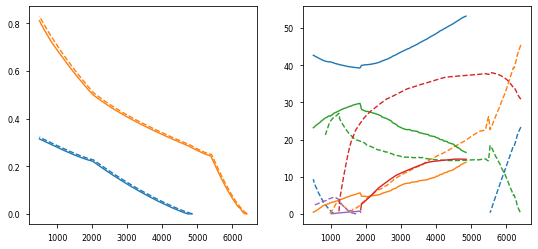

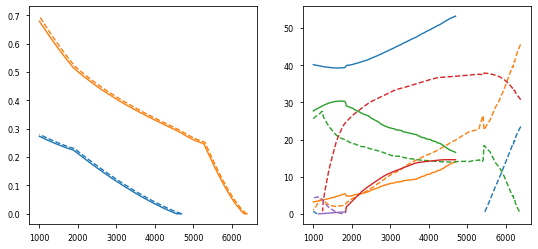

In [5]:
for i in range(n):
    res_lz, res_px = results[i]
    f,a = plt.subplots(1,2,figsize=(9,4))
    a[0].plot(res_lz.P,res_lz.F_MELTS,c='C0')
    a[0].plot(res_lz.P,res_lz.F_pyMelt,c='C0',ls='--')
    a[0].plot(res_px.P,res_px.F_MELTS,c='C1')
    a[0].plot(res_px.P,res_px.F_pyMelt,c='C1',ls='--')
    
    for j, ph in zip(range(5),['Olivine','Augite','Orthopyroxene','Garnet','Spinel']):
        if ph in res_lz.columns:
            a[1].plot(res_lz.P,res_lz[ph],c='C'+str(j),label=ph)
        if ph in res_px.columns:
            a[1].plot(res_px.P,res_px[ph],c='C'+str(j),label=ph,ls='--')
    
    plt.show()

## Define functions for the trace element calculations
The trace elements are calculated using the phase modes predicted by MELTS, and assuming near-fractional melting. The extracted melts are calculated using the pooled melts over the interval $\delta X$ (melt generated between $P$ and $P + \delta P$), but the melt left in the porosity reflects the instantaneous near-fractional melt at the end of the same interval.

The first function defined here iterates through each row and handles the changing bulk composition during melting. The arguments `dm` and `em` are the trace element concentrations in each lithology, and `mineralDs` are the mineral-specific partition coefficients in a pandas DataFrame.

In [6]:
def calctraces_frac(fracresults_kr4003, fracresults_kg1, dm, em, mineralDs, phi=0.005):
    
    # Lherzolite/DM component
    # Create a dataframe for storing the results
    trace_results = pd.DataFrame()
    # Set the initial bulk composition
    dmmc0 = dm
    # Iterate through each pressure step
    for i, row in fracresults_kr4003.iterrows():
        # Extract the proportions of residual phases
        phase_props = extractPhaseProps(row)
        # Calculate the pooled continuous melts over the dX melting interval
        Cl = calcTraceContinuousPooled(dmmc0,mineralDs,phase_props,row.X,phi)
        # Calculate the instantaneous continuous melt (which will be present in the porosity at this step)
        Clphi = calcTraceContinuousIncrement(dmmc0,mineralDs,phase_props,row.X,phi)
        # Store the pooled melt composition
        trace_results = trace_results.append(Cl,ignore_index=True)
        # Adjust the bulk composition for the melt removed.
        if row.X-phi > 0:
            dmmc0 = dmmc0 - row.X*Cl + phi*Clphi
    # Store the results
    trace_fracresults_kr4003 = trace_results
    
    # Pyroxenite/EM component
    # Create a dataframe for storing the results
    trace_results = pd.DataFrame()
    # Set the initial bulk composition
    emc0 = em
    # Iterate through each pressure step
    for i, row in fracresults_kg1.iterrows():
        # Extract the proportions of residual phases
        phase_props = extractPhaseProps(row)
        # Calculate the pooled continuous melts over the dX melting interval
        Cl = calcTraceContinuousPooled(emc0,mineralDs,phase_props,row.X,phi)
        # Calculate the instantaneous continuous melt (which will be present in the porosity at this step)
        Clphi = calcTraceContinuousIncrement(emc0,mineralDs,phase_props,row.X,phi)
        # Store the pooled melt composition
        trace_results = trace_results.append(Cl,ignore_index=True)
        # Adjust the bulk composition for the melt removed.
        if row.X-phi > 0:
            emc0 = emc0 - row.X*Cl + Clphi*phi
    # Store the results
    trace_fracresults_kg1 = trace_results
    
    return trace_fracresults_kr4003, trace_fracresults_kg1



This equation calculates the pooled continuous melts over the melting step. This equation must be used so that the discretisation doesn't affect the results. This uses the "effective partition coefficient" from the White Geochemistry textbook, along with the equation from pooled fractional melts. The argument `F` must be the melt actually present, not the total melt fraction.

In [7]:
def calcTraceContinuousPooled(C0, D, phase_props, F, phi=0.005):
    # Make sure phase proportions sum to 1
    summed = 0.0
    for ph in phase_props.keys():
        if np.isnan(phase_props[ph]) == False:
            summed += phase_props[ph]
        else:
            phase_props[ph] = 0.0
    phase_props = phase_props/summed

    bulkD = {}
    for i, row in D.iterrows():
        bD = 0.0
        for ph in row.index:
            bD += phase_props[ph]*row[ph]
        bulkD[row.name] = bD
            

    # Calculate melt trace element concentration, assuming aggregate continuous melting
    Cl = {}
    for el in C0.index:
        Dprime = (1-phi)*bulkD[el]+phi
        Cl[el] = C0[el]/F*(1-(1-F)**(1/Dprime))
        
    Cl = pd.Series(Cl)
    return Cl



This function calculates the instantaneous (continuous) melt present, provided `F` is set to the amount of melt present, not the total melt fraction.

In [8]:
def calcTraceContinuousIncrement(C0, D, phase_props, F, phi=0.005):
    # Make sure phase proportions sum to 1
    summed = 0.0
    for ph in phase_props.keys():
        if np.isnan(phase_props[ph]) == False:
            summed += phase_props[ph]
        else:
            phase_props[ph] = 0.0
    phase_props = phase_props/summed

    bulkD = {}
    for i, row in D.iterrows():
        bD = 0.0
        for ph in row.index:
            bD += phase_props[ph]*row[ph]
        bulkD[row.name] = bD
            

    # Calculate melt trace element concentration, assuming aggregate continuous melting
    Cl = {}
    for el in C0.index:
        Cl[el] = C0[el]/((1-phi)*bulkD[el]+phi)*(1-F+phi)**((1-phi)*(1-bulkD[el])/((1-phi)*bulkD[el]+phi))
        
    Cl = pd.Series(Cl)
    return Cl

This function provides a convenient method for extracting the phase proportions in order to calculate the bulk partition coefficients

In [9]:
def extractPhaseProps(row):
    phase_props = {}
    for ph, phnm in zip(['Olivine','Orthopyroxene','Spinel','Garnet','Augite','Feldspar'],['ol','opx','sp','gt','cpx','fsp']):
        if ph in row.index:
            phase_props[phnm] = row[ph]
        else:
            phase_props[phnm] = 0.0
    return pd.Series(phase_props)

## Set up the partition coefficients.
The calculation uses mineral specific partition coefficients. Most of these are set to the values in the `traceDs.csv` file (see Supplementary Text for references), but the coefficients for Pb are changed to be equal to those for Ce, to reflect the empirical similarity in partitiong behaviour. A pressure dependent Na partition coefficient is set up below.

Import the csv file, and alter the coefficients as necessary.

In [10]:
mineralDs = pd.read_csv('traceDs.csv',index_col='el')
mineralDs = mineralDs.fillna(0)
mineralDs.loc['Pb'] = mineralDs.loc['Ce']
# K partition coefficient changes substantially with pressure. Doesn't become compatible
# like Na, so will approximate by using a value more typical of higher P.
mineralDs.loc['K','cpx'] = 0.1
mineralDs

,ol,cpx,opx,gt,sp,fsp
el,,,,,,
Na,0.00001,0.2000,0.0500,0.0400,0.0000,0.390
K,0.00018,0.1000,0.0010,0.0010,0.0001,0.180
Ti,0.02000,0.1800,0.1000,0.2800,0.1500,0.040
Sr,0.00019,0.1283,0.0070,0.0001,0.0000,2.000
La,0.00040,0.0540,0.0020,0.0100,0.0100,0.270
Ce,0.00050,0.0980,0.0030,0.0210,0.0100,0.200
Nd,0.00100,0.2100,0.0068,0.0870,0.0100,0.140
Yb,0.00150,0.2800,0.0490,4.0300,0.0100,0.031
Pb,0.00050,0.0980,0.0030,0.0210,0.0100,0.200


#### Melts underpredicts D(Na) 
The experimental partitioning behaviour changes strongly as a function of P. MELTS is systematically wrong (as shown in the diagram in Jennings2015). However, THERMOCALC does a reasonable job, and predicts that Na becomes compatible with increasing P, which would be consistent with the Iceland data.

The following data is calculated from the solidus for KLB-1 for thermocalc. C.f. the figure in Jennings2015.

In [11]:
DNa = np.array([0.187414021,0.197142109,0.208309585,0.220437767,0.234228351,0.248935296,0.268881788,0.288198975,0.309301424,0.334434069,0.362573536,0.394283216,
                0.432139215,0.474823239,0.521875762,0.581160617,0.640761955,0.718728098,0.797803819,0.8945684,1.001560356,1.117631447,1.240094328,1.390387036,
                1.579481032,1.73793823])
P = np.array([10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60])

Set up an interpolation function for the partition coefficients:

In [12]:
DNa_varP = interp1d(P,DNa, kind='linear', fill_value = "extrapolate")

Check the function behaviour:

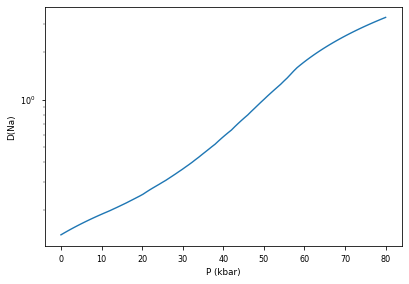

In [13]:
f,a = plt.subplots()
x = np.linspace(0,80,100)
y = DNa_varP(x)
a.plot(x,y)
a.set_yscale('log')
a.set_ylabel('D(Na)')
a.set_xlabel('P (kbar)')
plt.show()

Define a function for calculating the Na concentration according to the pressure-dependent partition coefficient.

In [14]:
def redoNaConc(trace_results_kr4003, trace_results_kg1, fracresults_kr4003, fracresults_kg1, dm, em, phi=0.005):
    dmmc0 = pd.Series({'Na':dm['Na']})
    mineralDsupd = mineralDs.copy()
    
    for i, row in fracresults_kr4003.iterrows():
        phase_props = extractPhaseProps(row)
        mineralDsupd['cpx']['Na'] = DNa_varP(row.P/100)
        Cl = calcTraceContinuousIncrement(dmmc0, mineralDsupd ,phase_props,row.X, phi)
        Clphi = calcTraceContinuousIncrement(dmmc0, mineralDsupd ,phase_props,row.X, phi)
        trace_results_kr4003.loc[i,'Na_new'] = Cl['Na']
        dmmc0 = dmmc0 - row.X*Cl + phi*Clphi

    emc0 = pd.Series({'Na':em['Na']})
    for i, row in fracresults_kg1.iterrows():
        phase_props = extractPhaseProps(row)
        mineralDsupd['cpx']['Na'] = DNa_varP(row.P/100)
        Cl = calcTraceContinuousIncrement(emc0,mineralDsupd,phase_props,row.X, phi)
        Clphi = calcTraceContinuousIncrement(emc0,mineralDsupd,phase_props,row.X, phi)
        trace_results_kg1.loc[i,'Na_new'] = Cl['Na']
        emc0 = emc0 - row.X*Cl + phi*Clphi
    
    return trace_results_kr4003, trace_results_kg1

## Set up the trace element concentrations
See the supplementary text for references.

In [15]:
dmm = pd.Series({
     'La': 0.134,
     'Ce': 0.421,
     'Pb': 0.014,
     'Nd': 0.483,
     'Sr': 6.092,
     'Ti': 0.20,
     'Yb': 0.348,
     'K': 0.006/2,
     'Na': 0.13*4 
                })

subducted_crust = pd.Series({
    'La':  1.68, 
    'Ce':  5.89,
    'Pb':  0.09,
    'Nd':  7.45,
    'Sr': 81.0,
    'Ti':  0.5,
    'Yb':  2.99,
    'K': 0.12*1.5,
    'Na': 1.52/3
})


## Run the calculations

In [16]:
phi=0.005
traces = []

for i in range(n):
    [results_kr4003, results_kg1] = results[i]
    traces_kr4003, traces_kg1 = calctraces_frac(results_kr4003,results_kg1,dmm,subducted_crust,mineralDs,phi=phi)
    traces_kr4003, traces_kg1 = redoNaConc(traces_kr4003, traces_kg1, results_kr4003, results_kg1, dmm,subducted_crust,phi=phi)

    traces.append([traces_kr4003, traces_kg1])

Save the results in csv files for use in the next notebook.

In [17]:
for i in range(n):
    traces[i][0].to_csv('kr4003_traces_'+str(i)+'.csv')
    traces[i][1].to_csv('kg1_traces_'+str(i)+'.csv')